In [1]:
import pandas as pd
import numpy as np
import torch
import utils.print as print_f
import os

from utils.engine import evaluate, get_iou_types
from utils.plot import plot_losses, plot_performance
from data.strs import TaskStrs, SourceStrs, FusionStrs

from models.utils import get_model_size_in_MB
from models.build import create_model_from_setup
from models.setup import ModelSetup
from models.train import TrainingInfo, get_task_metric_name_from_standard
from utils.save import check_best, end_train, get_data_from_metric_logger
from data.load import get_datasets, get_dataloaders
from IPython.display import clear_output
from utils.eval import get_performance
from utils.train import get_optimiser, get_lr_scheduler, print_params_setup, get_coco_eval_params, get_dynamic_loss
from utils.init import reproducibility, clean_memory_get_device
from data.paths import MIMIC_EYE_PATH
# from datetime import datetime
# from models.dynamic_loss import DynamicWeightedLoss
from utils.engine import train_one_epoch, evaluate
from torch import optim
from models.setup import ModelSetup
from data.paths import MIMIC_EYE_PATH, PHYSIONET_PATH
from models.load import get_trained_model
from models.load import load_cl_pretrained


# from data.load import seed_worker, get_dataloader_g

## Suppress the assignement warning from pandas.r
pd.options.mode.chained_assignment = None  # default='warn'

## Supress user warning
import warnings
warnings.filterwarnings("ignore")

from models.components.task_performers import ObjectDetectionPerformer
from data.constants import DEFAULT_MIMIC_CLINICAL_NUM_COLS, DEFAULT_MIMIC_CLINICAL_CAT_COLS

%matplotlib inline

In [2]:
from enum import Enum

class TrainedModels(Enum):
    continue_training = "xray-clinical-cl_val_accuracy_0_2879_test_accuracy_0_2759_epoch65_08-31-2023 09-21-53_discrete_clinical__no64"

In [3]:
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:256"
# 'PYTORCH_CUDA_ALLOC_CONF=max_split_size_mb:512'
device = clean_memory_get_device()
reproducibility()
if torch.cuda.is_available():
    print(torch.cuda.memory_summary())

This notebook will running on device: [CUDA]
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |       0 B  |       0 B  |       0 B  |       0 B  |
|       from large pool |       0 B  |       0 B  |       0 B  |       0 B  |
|       from small pool |       0 B  |       0 B  |       0 B  |       0 B  |
|---------------------------------------------------------------------------|
| Active memory         |       0 B  |       0 B  |       0 B  |       0 B  |
|       from large 

In [4]:
get_epoch_from_model = lambda select_model: int(([substr for substr in select_model.value.split("_") if "epoch" in substr][0]).replace("epoch", ""))
get_model_name = lambda select_model: str(select_model).split(".")[-1]

In [5]:
get_model_name

<function __main__.<lambda>(select_model)>

In [6]:
train_more_models = [
    TrainedModels.continue_training
]

target_epoch = 200

# need to create a list for storing the namimg.
train_infos = []

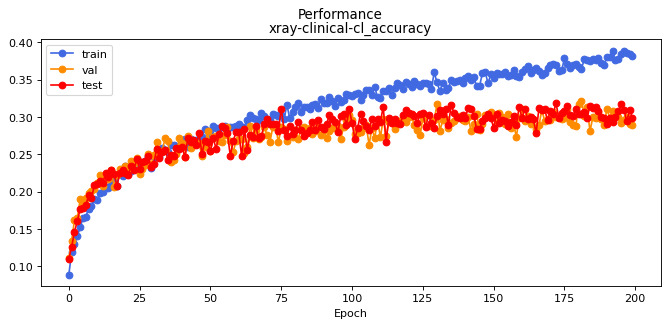

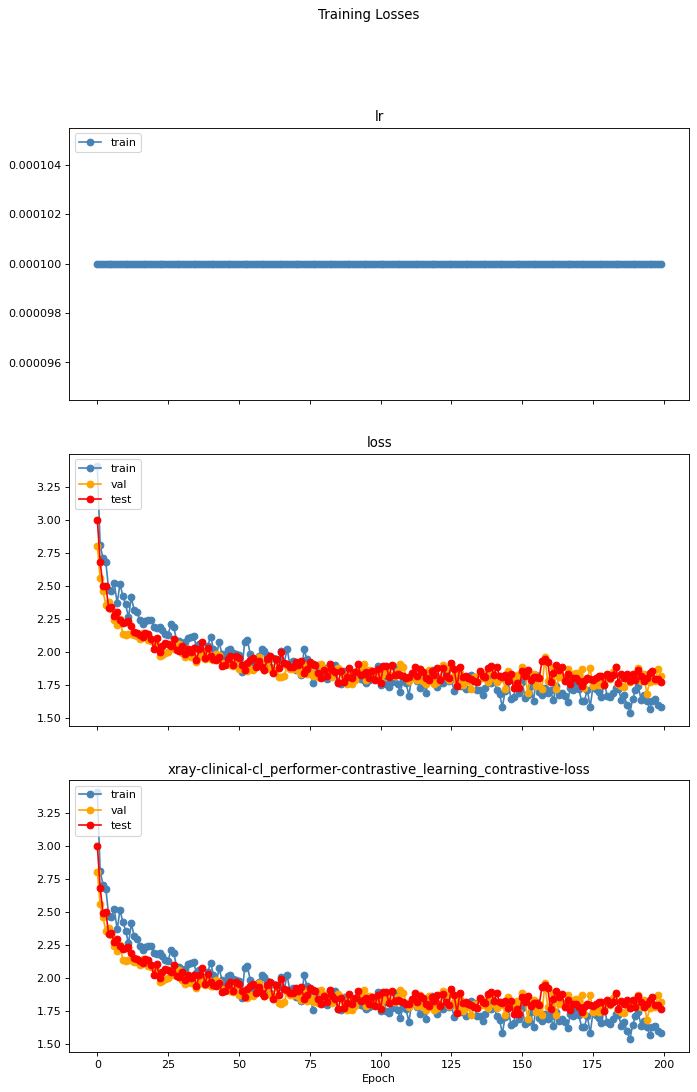

====================| Epoch [200] Done | It has took [1320.20] min, Avg time: [396.06] sec/epoch | Estimate time for [135] epochs: [891.13] min | Epoch took [6770] sec |  xray-clinical-cl_accuracy Patience [18] |====================
====================| Training Done, start testing! | [200] Epochs Training time: [79212] seconds, Avg time / Epoch: [396.06] seconds====================
====================Best Performance model has been saved to: [{'xray-clinical-cl_accuracy': 'xray-clinical-cl_val_accuracy_0_3218_test_accuracy_0_3045_epoch182_09-08-2023 15-01-57_discrete_clinical__no64'}]====================
====================The final model has been saved to: [xray-clinical-cl_val_accuracy_0_2886_test_accuracy_0_2985_epoch200_09-09-2023 15-51-16_discrete_clinical__no64]====================


In [7]:
# we have to mention that in order to provide objective evaluation, we compromise the dataset size, which also nagatively afftect the performance and generlaization.
for select_model in train_more_models:

    device = clean_memory_get_device()
    reproducibility()


    ### model and setup loadinge from the saved files.
    model, train_info, optimizer, dynamic_loss_weight = get_trained_model(
        select_model,
        device,
    )
    model = model.to(device)
    model.train()

    setup = train_info.model_setup


    # load pretrained happening here.
    if len(setup.cl_pretrained_load_params) > 0:
        # load weights
        for cl_param in setup.cl_pretrained_load_params:
            print(f"Pretrained Model load for part [{cl_param.model_part}] from [{cl_param.model_name}], fix weight [{cl_param.fix_wieght}]")
            model = load_cl_pretrained(model, cl_param.model_name, cl_param.model_part, cl_param.fix_wieght)

    assert (
        len(setup.sources) > 0 and len(setup.tasks) > 0
    ), "Need at least one source and task."

    if "lesion-detection" in model.task_performers:
        model.task_performers["lesion-detection"].roi_heads.score_thresh = 0

    print_f.print_title("Preparing for the training.")

    train_info.all_tasks = list(model.task_performers.keys())
    print(f" Model Size [{get_model_size_in_MB(model):.3f}] MB")
    
    ################ Datasets ################
   ################ Datasets ################
    relfacx_dataset_params_dict = {
        "MIMIC_EYE_PATH": MIMIC_EYE_PATH,
        "labels_cols": setup.lesion_label_cols,
        "with_xrays_input": SourceStrs.XRAYS in setup.sources,
        "with_clincal_input": SourceStrs.CLINICAL in setup.sources or SourceStrs.CLINICAL_1D in setup.sources,
        "with_fixations_input": SourceStrs.FIXATIONS in setup.sources,
        "fixations_mode_input": setup.fiaxtions_mode_input,
        "with_bboxes_label": TaskStrs.LESION_DETECTION in setup.tasks,
        "with_fixations_label": TaskStrs.FIXATION_GENERATION in setup.tasks,
        "fixations_mode_label": setup.fiaxtions_mode_label,
        "with_chexpert_label": TaskStrs.CHEXPERT_CLASSIFICATION in setup.tasks,
        "with_negbio_label": TaskStrs.NEGBIO_CLASSIFICATION in setup.tasks,
        "clinical_numerical_cols": setup.clinical_num,
        "clinical_categorical_cols": setup.clinical_cat,
        "image_size": setup.image_size,
        "image_mean": setup.image_mean,
        "image_std": setup.image_std,
        "with_clinical_label": setup.with_clinical_label,
        "normalise_clinical_num": setup.normalise_clinical_num,
        "bbox_to_mask": setup.lesion_detection_use_mask,
        "use_clinical_df": setup.use_clinical_df,
    }


    physionet_dataset_params_dict = {
        "PHYSIONET_PATH": PHYSIONET_PATH,
        # "labels_cols": setup.lesion_label_cols,
        "with_xrays_input": SourceStrs.XRAYS in setup.sources,
        "with_clincal_input": SourceStrs.CLINICAL in setup.sources or SourceStrs.CLINICAL_1D in setup.sources,
        # "with_fixations_input": SourceStrs.FIXATIONS in setup.sources,
        # "fixations_mode_input": setup.fiaxtions_mode_input,
        # "with_bboxes_label": TaskStrs.LESION_DETECTION in setup.tasks,
        # "with_fixations_label": TaskStrs.FIXATION_GENERATION in setup.tasks,
        # "fixations_mode_label": setup.fiaxtions_mode_label,
        "with_chexpert_label": TaskStrs.CHEXPERT_CLASSIFICATION in setup.tasks,
        "with_negbio_label": TaskStrs.NEGBIO_CLASSIFICATION in setup.tasks,
        "clinical_numerical_cols": setup.clinical_num,
        "clinical_categorical_cols": setup.clinical_cat,
        "image_size": setup.image_size,
        "image_mean": setup.image_mean,
        "image_std": setup.image_std,
        "with_clinical_label": setup.with_clinical_label,
        "normalise_clinical_num": setup.normalise_clinical_num,
        "use_aug": setup.use_aug_for_cl,
        # "bbox_to_mask": setup.lesion_detection_use_mask,
        # "use_clinical_df": setup.use_clinical_df,
    }

    detect_eval_dataset, train_dataset, val_dataset, test_dataset = get_datasets(
        dataset_params_dict= physionet_dataset_params_dict if setup.use_physionet_df else relfacx_dataset_params_dict,
        using_reflacx= not setup.use_physionet_df,
    )

    train_dataloader, val_dataloader, test_dataloader = get_dataloaders(
        train_dataset,
        val_dataset,
        test_dataset,
        batch_size=setup.batch_size,
    )

    train_coco = None
    val_coco = None
    test_coco = None
    eval_params_dict = None

    if TaskStrs.LESION_DETECTION in setup.tasks:
            train_coco, val_coco, test_coco, eval_params_dict = get_coco_eval_params(
                source_name=SourceStrs.XRAYS,
                task_name=TaskStrs.LESION_DETECTION,
                train_dataloader=train_dataloader,
                val_dataloader=val_dataloader,
                test_dataloader=test_dataloader,
                detect_eval_dataset=detect_eval_dataset,
                iou_thrs=setup.iou_thrs,
                use_iobb=setup.use_iobb,
                maxDets=setup.maxDets,
            )

    train_info.timer.start_training()

    dynamic_loss_weight = None
    if setup.use_dynamic_weight:
        dynamic_loss_weight = get_dynamic_loss(
            loss_keys=model.get_all_losses_keys(), device=device
        )

    params = model.get_all_params(dynamic_loss_weight=dynamic_loss_weight)


    iou_types = get_iou_types(model, setup)
    optimizer = get_optimiser(params, setup)

    lr_scheduler_dict = {}
    
    for st in setup.performance_standards:
        lr_scheduler_dict[get_task_metric_name_from_standard(st)] = get_lr_scheduler(optimizer, setup)

    print_f.print_title(
        f"Start training. Preparing Took [{train_info.timer.has_took_sec_from_init()}] sec"
    )

    last_trainng_epoch = train_info.epoch
    num_epochs_to_run = target_epoch - last_trainng_epoch

    train_info.timer.start_training()

    val_loss = None

    # Start the training from here.
    for e in range(last_trainng_epoch+1, target_epoch+1):

        trained_model_prt = ("=" * 30) + "Trained Models" + ("=" * 30)
        print(trained_model_prt)
        for _t in train_infos:
            print(_t.best_performance_model_path)
        print(("=" * len(trained_model_prt)))

        print_f.print_title(f"Training model: [{setup.name}]")
        
        print(train_info)
        if dynamic_loss_weight:
            for k, v in dynamic_loss_weight.params.items():
                print(f"[{k}]: {v.item():.4f}")

        train_info.epoch = e

        train_info.timer.start_epoch()

        
        if (
            any(
                [
                    isinstance(p, ObjectDetectionPerformer)
                    for p in model.task_performers.values()
                ]
            )
            and train_info.epoch > setup.gt_in_train_till
        ):
            model.task_performers[
                TaskStrs.LESION_DETECTION
            ].roi_heads.use_gt_in_train = False


        ###### Perform training and show the training result here ######
        model.train()

        train_info.last_train_evaluator, train_loger = train_one_epoch(
            setup=setup,
            model=model,
            optimizer=optimizer,
            data_loader=train_dataloader,
            # data_loader=test_dataloader,
            device=device,
            epoch=train_info.epoch,
            print_freq=10,
            iou_types=iou_types,
            coco=train_coco,
            evaluate_on_run=True,
            params_dict=eval_params_dict,
            dynamic_loss_weight=dynamic_loss_weight,
            return_dt_gt=True,
        )

        # train_info.train_evaluators.append(train_evaluator)
        train_info.train_losses.append(get_data_from_metric_logger(train_loger))
        ################################################################

        ####### Put the model into evaluation mode, start evaluating the current model #######
        model.eval()

        train_info.last_val_evaluator, val_logger = evaluate(
            setup=setup,
            model=model,
            data_loader=val_dataloader,
            device=device,
            params_dict=eval_params_dict,
            coco=val_coco,
            iou_types=iou_types,
            return_dt_gt=True,
        )

        # train_info.val_evaluators.append(val_evaluator)
        train_info.val_losses.append(get_data_from_metric_logger(val_logger))

        train_info.performance["train"].append(
            get_performance(
                train_dataset,
                train_info.all_tasks,
                train_info.last_train_evaluator,
                iouThr=None,
                areaRng="all",
                maxDets=30,
            )
        )

        train_info.performance["val"].append(
            get_performance(
                val_dataset,
                train_info.all_tasks,
                train_info.last_val_evaluator,
                iouThr=None,
                areaRng="all",
                maxDets=30,
            )
        )

        test_performance = None
        if setup.measure_test:
            train_info.test_evaluator, test_logger = evaluate(
                setup=setup,
                model=model,
                data_loader=test_dataloader,
                device=device,
                params_dict=eval_params_dict,
                coco=test_coco,
                iou_types=iou_types,
                return_dt_gt=True,
            )
            train_info.test_losses.append(get_data_from_metric_logger(test_logger))

            test_performance = get_performance(
                test_dataset,
                train_info.all_tasks,
                train_info.test_evaluator,
            )
            train_info.performance["test"].append(test_performance)

        # update the learning rate

        val_performance_dict = {
            get_task_metric_name_from_standard(s): train_info.performance["val"][-1][s["task"]][s["metric"]]
            for s in setup.performance_standards
        }

        epoch_took, sec_already_took, speed = train_info.timer.end_epoch(
            train_info.epoch
        )


        if train_info.epoch > setup.warmup_epochs:
            if not lr_scheduler_dict is None and len(lr_scheduler_dict) > 0 :
                all_stop = []
                for st in setup.performance_standards:
                    name = get_task_metric_name_from_standard(st)
                    lr_scheduler_dict[name].step(val_performance_dict[name])
                    
                    if lr_scheduler_dict[name].num_bad_epochs > setup.real_stop_patience:
                        all_stop.append(True)
                    else: 
                        all_stop.append(False)
                        
                if setup.reduceLROnPlateau_full_stop and all(all_stop):
                    break

        # Clean everything before we show the evaluating result in this stage, so we can inspect the training progress.
        clear_output()

        # if model_setup.record_training_performance:
        plot_performance(
            performance=train_info.performance,
            all_tasks=train_info.all_tasks,
            fig_title="Performance",
        )

        plot_losses(
            train_info.train_losses,
            train_info.val_losses,
            test_logers=train_info.test_losses,
        )

        # previous_time = current_time
        # current_time = datetime.now()
        # epoch_took = current_time - previous_time

        # sec_took = (current_time - train_info.start_t).seconds
        # speed = sec_took / train_info.epoch
        print_str = f"| Epoch [{train_info.epoch}] Done | It has took [{sec_already_took/60:.2f}] min, Avg time: [{speed:.2f}] sec/epoch | Estimate time for [{num_epochs_to_run}] epochs: [{speed*num_epochs_to_run/60:.2f}] min | Epoch took [{epoch_took.seconds}] sec | "

        if lr_scheduler_dict and len(lr_scheduler_dict) > 0:
            for k in lr_scheduler_dict.keys():
                print_str += f" {k} Patience [{lr_scheduler_dict[k].num_bad_epochs}] |"

        print_f.print_title(print_str)

        #######################################################################################
        if train_info.epoch > setup.warmup_epochs and setup.save_early_stop_model:
        # if setup.save_early_stop_model:
            val_performance_dict = {
                get_task_metric_name_from_standard(s): train_info.performance["val"][-1][s["task"]][s["metric"]]
                for s in setup.performance_standards
            }
            val_performance_dict, train_info = check_best(
                setup=setup,
                # val_performance_value=train_info.performance["val"][-1][
                #     setup.performance_standard_task
                # ][setup.performance_standard_metric],
                val_performance_dict=val_performance_dict,
                device=device,
                eval_params_dict=eval_params_dict,
                train_info=train_info,
                model=model,
                optim=optimizer,
                test_dataloader=test_dataloader,
                test_coco=test_coco,
                iou_types=iou_types,
                dynamic_weight=dynamic_loss_weight,
                test_performance=test_performance,
            )

    train_info = end_train(
        setup=setup,
        train_info=train_info,
        model=model,
        optim=optimizer,
        eval_params_dict=eval_params_dict,
        last_val_performance=train_info.performance["val"][-1][
            setup.performance_standards[0]['task']
        ][setup.performance_standards[0]['metric']],
        test_dataloader=test_dataloader,
        device=device,        test_coco=test_coco,
        iou_types=iou_types,
        dynamic_weight=dynamic_loss_weight,
        test_performance=test_performance,
    )

    train_infos.append(train_info)

In [8]:
# train_info = end_train(
#     setup=setup,
#     train_info=train_info,
#     model=model,
#     optim=optimizer,
#     eval_params_dict=eval_params_dict,
#     last_val_performance=train_info.performance["val"][-1][
#         setup.performance_standards[0]['task']
#     ][setup.performance_standards[0]['metric']],
#     test_dataloader=test_dataloader,
#     device=device,
#     test_coco=test_coco,
#     iou_types=iou_types,    
#     dynamic_weight=dynamic_loss_weight,
#     test_performance=test_performance,
# )

# train_infos.append(train_info)

====================| Training Done, start testing! | [200] Epochs Training time: [79213] seconds, Avg time / Epoch: [396.065] seconds====================
====================Best Performance model has been saved to: [{'xray-clinical-cl_accuracy': 'xray-clinical-cl_val_accuracy_0_3218_test_accuracy_0_3045_epoch182_09-08-2023 15-01-57_discrete_clinical__no64'}]====================
====================The final model has been saved to: [xray-clinical-cl_val_accuracy_0_2886_test_accuracy_0_2985_epoch200_09-09-2023 15-51-16_discrete_clinical__no64]====================


========================================For Training [discrete_clinical__no64]========================================
ModelSetup(get_performance_iou=None, get_performance_areaRng='all', name='discrete_clinical__no64', sources=['xrays', 'clinical_1d'], tasks=['xray-clinical-cl'], fusor='no-action', using_backbone_for_clinical=True, decoder_channels=[128, 64, 32, 16, 8], lesion_label_cols=['Pulmonary edema', 'Enlarged cardiac silhouette', 'Consolidation', 'Atelectasis', 'Pleural abnormality'], save_early_stop_model=True, normalise_clinical_num=True, record_training_performance=False, backbone='resnet18', optimiser='sgd', lr=0.0001, weight_decay=0.0001, sgb_momentum=0.9, use_aug_for_cl=True, image_backbone_pretrained=True, heatmap_backbone_pretrained=False, image_size=512, image_mean=[0.485, 0.456, 0.406], image_std=[0.229, 0.224, 0.225], backbone_out_channels=64, batch_size=16, warmup_epochs=10, model_warmup_epochs=0, loss_warmup_epochs=0, lr_scheduler='ReduceLROnPlateau', reduceLROnPla

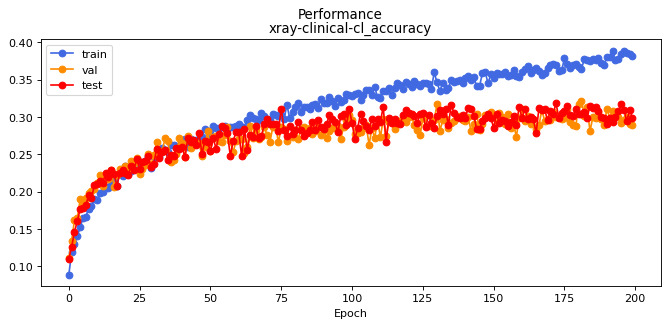

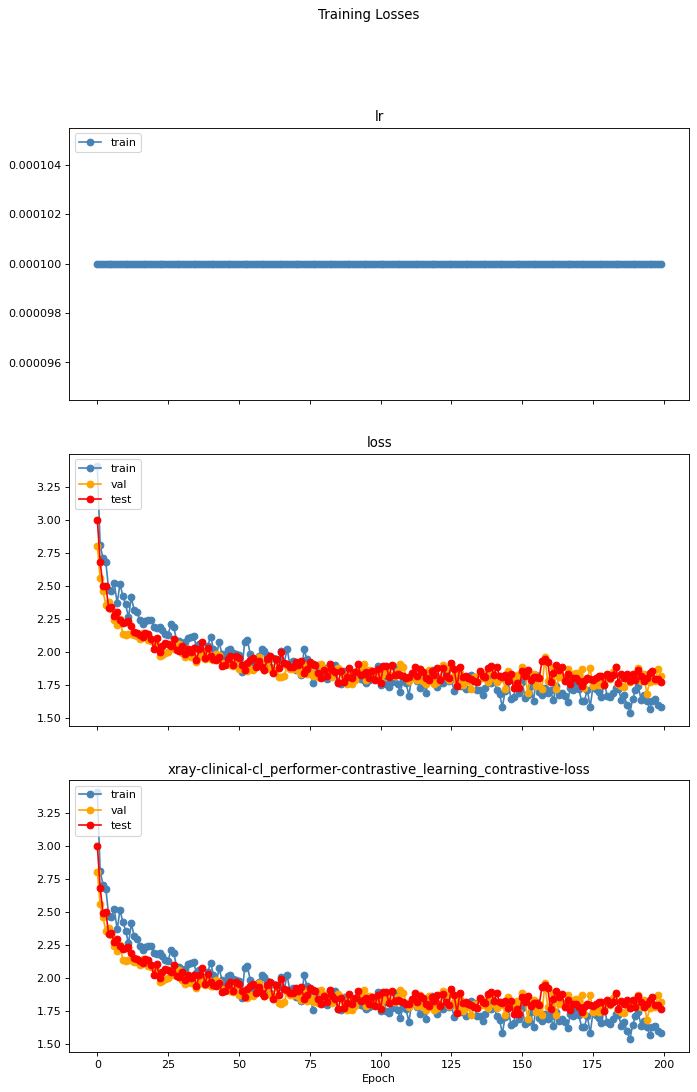

========================================For Training [discrete_clinical__no64]========================================
ModelSetup(get_performance_iou=None, get_performance_areaRng='all', name='discrete_clinical__no64', sources=['xrays', 'clinical_1d'], tasks=['xray-clinical-cl'], fusor='no-action', using_backbone_for_clinical=True, decoder_channels=[128, 64, 32, 16, 8], lesion_label_cols=['Pulmonary edema', 'Enlarged cardiac silhouette', 'Consolidation', 'Atelectasis', 'Pleural abnormality'], save_early_stop_model=True, normalise_clinical_num=True, record_training_performance=False, backbone='resnet18', optimiser='sgd', lr=0.0001, weight_decay=0.0001, sgb_momentum=0.9, use_aug_for_cl=True, image_backbone_pretrained=True, heatmap_backbone_pretrained=False, image_size=512, image_mean=[0.485, 0.456, 0.406], image_std=[0.229, 0.224, 0.225], backbone_out_channels=64, batch_size=16, warmup_epochs=10, model_warmup_epochs=0, loss_warmup_epochs=0, lr_scheduler='ReduceLROnPlateau', reduceLROnPla

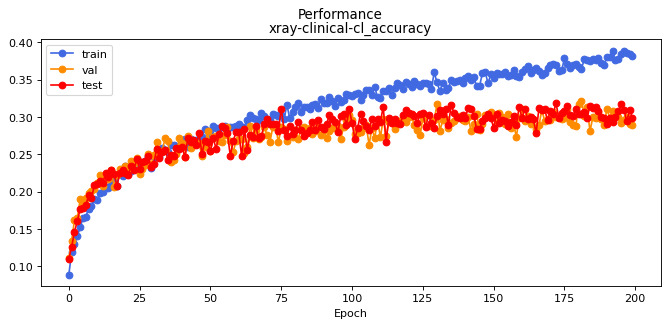

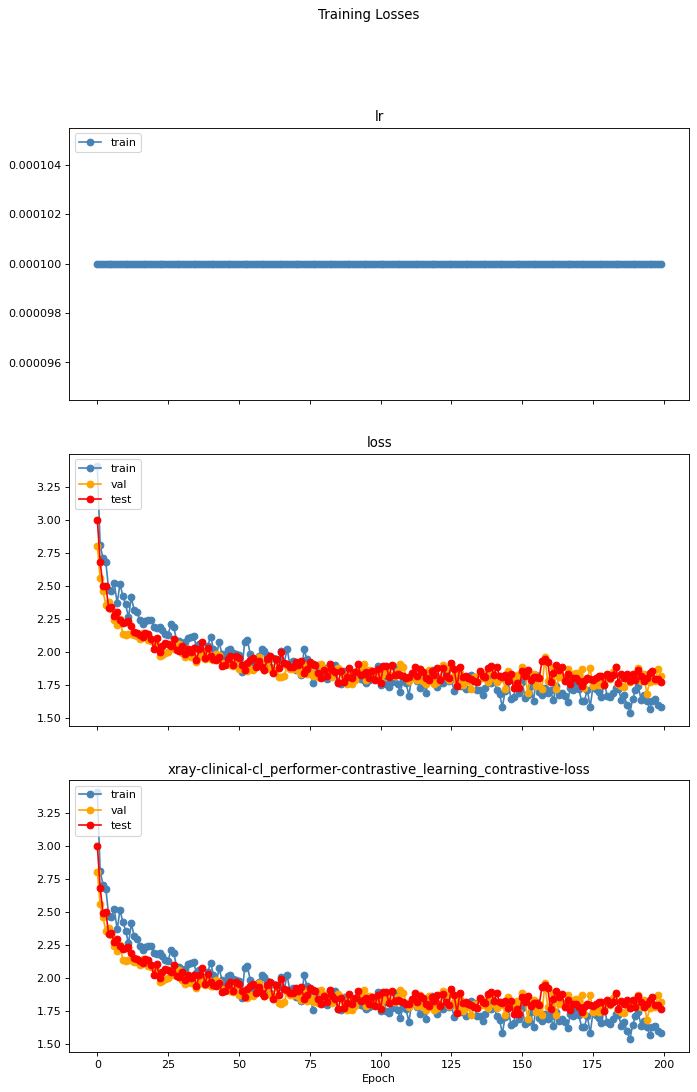

In [9]:
for t in train_infos :
    print(t)
    plot_performance(
        performance=t.performance,
        all_tasks=t.all_tasks,
        fig_title="Performance",
    )
    plot_losses(
        t.train_losses,
        t.val_losses,
        test_logers=t.test_losses,
    )

In [10]:
# trained models:

# Best performance model has been saved to: [{'xray-clinical-cl_accuracy': 'xray-clinical-cl_val_accuracy_0_0660_test_accuracy_0_0653_epoch11_06-06-2023 02-50-07_cl_physionet'}]
# The final model has been saved to: [xray-clinical-cl_val_accuracy_0_0438_test_accuracy_0_0511_epoch32_06-08-2023 12-20-41_cl_physionet]

# ====================| Training Done, start testing! | [101] Epochs Training time: [60218] seconds, Avg time / Epoch: [596.2178217821782] seconds====================
# ====================Best Performance model has been saved to: [{'xray-clinical-cl_accuracy': 'xray-clinical-cl_val_accuracy_0_0660_test_accuracy_0_0653_epoch11_06-06-2023 02-50-07_cl_physionet'}]====================
# ====================The final model has been saved to: [xray-clinical-cl_val_accuracy_0_0167_test_accuracy_0_0162_epoch101_06-19-2023 21-19-44_cl_physionet]====================